# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [55]:
# import libraries
from pyspark.sql import SparkSession
from pyspark.sql.functions import udf
from pyspark.sql.types import IntegerType, StringType, BooleanType, DateType
from pyspark.sql.functions import sum as Fsum
from pyspark.sql.functions import isnan, count, when, col, desc, udf, col, sort_array, asc, avg
from pyspark.sql.window import Window

from datetime import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

In [38]:
# create a Spark session
spark = SparkSession.builder.appName("Sparkify").getOrCreate()

# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [39]:
df = spark.read.json("mini_sparkify_event_data.json")
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [40]:
df = df.dropDuplicates()
df.count()

286500

In [41]:
df = df.dropna(how = "any", subset = ("userId", "sessionId"))
df = df.filter(df["userId"] != np.nan)
df = df.filter(df["sessionId"] != np.nan)
df.count()

278154

In [46]:
#timestamp
adjust_timestamp = udf(lambda x: datetime.fromtimestamp(x).strftime("%Y-%m-%d %H:%M"), DateType())
df = df.withColumn("Time", adjust_timestamp("page"))


In [54]:
#Number of unique users (by ID)
Num_Unique_Users = df.select('userId').distinct().count()
print("There are {} distinct users (by userID)".format(Num_Unique_Users))

#Number of different type of pages
Num_Unique_Pages = df.select('page').distinct().count()
print("There are {} distinct users (by userID)".format(Num_Unique_Pages))



There are {} distinct users (by userID)


In [56]:
#Plot count of user activities recorded in our dataset
user_count = df.groupBy('userId').count().orderBy("count").toPandas()
plt.figure(figsize = [20,10])
plt.hist(user_count['count'], bins=100)
plt.xlabel("Count of User Activities")
plt.ylabel("Frequency")
plt.title("Distribution of Count of User Activities")

NameError: name 'User' is not defined

<Figure size 1440x720 with 0 Axes>

Text(0.5, 1.0, 'Number of Page Activities Recorded VS Page Type')

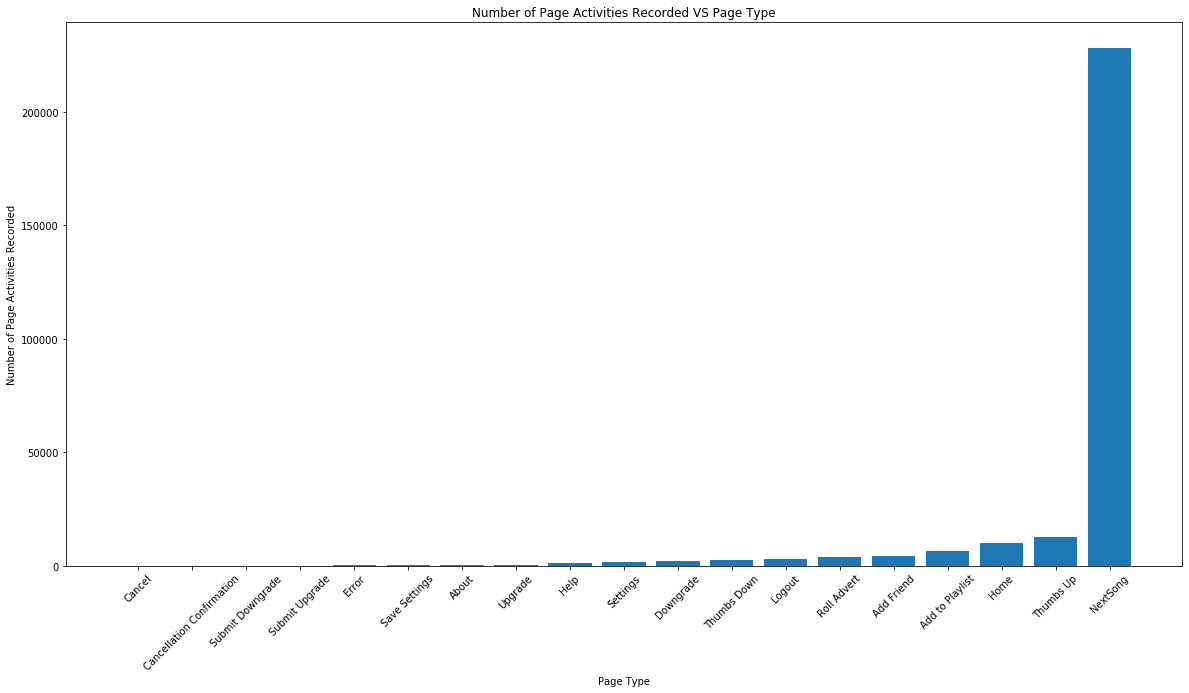

In [72]:
#Plot number of page activities recorded by page type
page_count = df.groupBy('page').count().orderBy("count").toPandas()
plt.figure(figsize = [20,10])
plt.bar(page_count['page'], page_count['count'])
plt.xticks(rotation = 45)
plt.xlabel("Page Type")
plt.ylabel("Number of Page Activities Recorded")
plt.title("Number of Page Activities Recorded VS Page Type")

Text(0.5, 1.0, 'Number of Users by Gender')

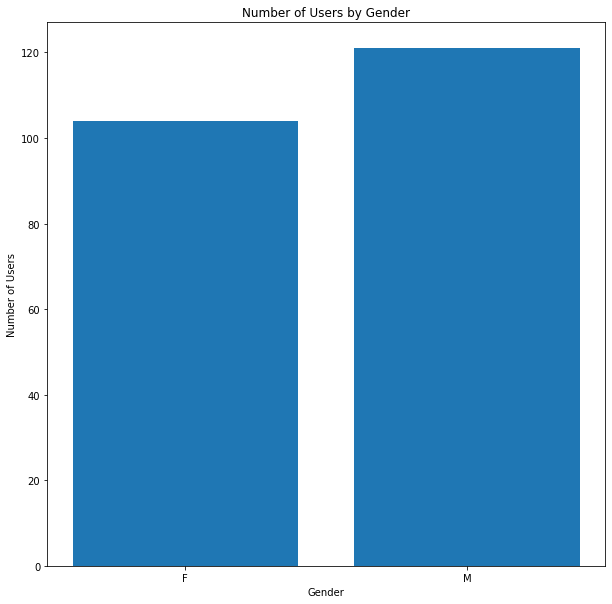

In [75]:
#Plot number of page activities recorded by page type
gender_count = df.select(['gender','userId']).distinct().groupBy('gender').count().toPandas()
plt.figure(figsize = [10,10])
plt.bar(gender_count['gender'], gender_count['count'])
plt.xlabel("Gender")
plt.ylabel("Number of Users")
plt.title("Number of Users by Gender")

Text(0.5, 1.0, 'Plot of Number of Users by Locationn')

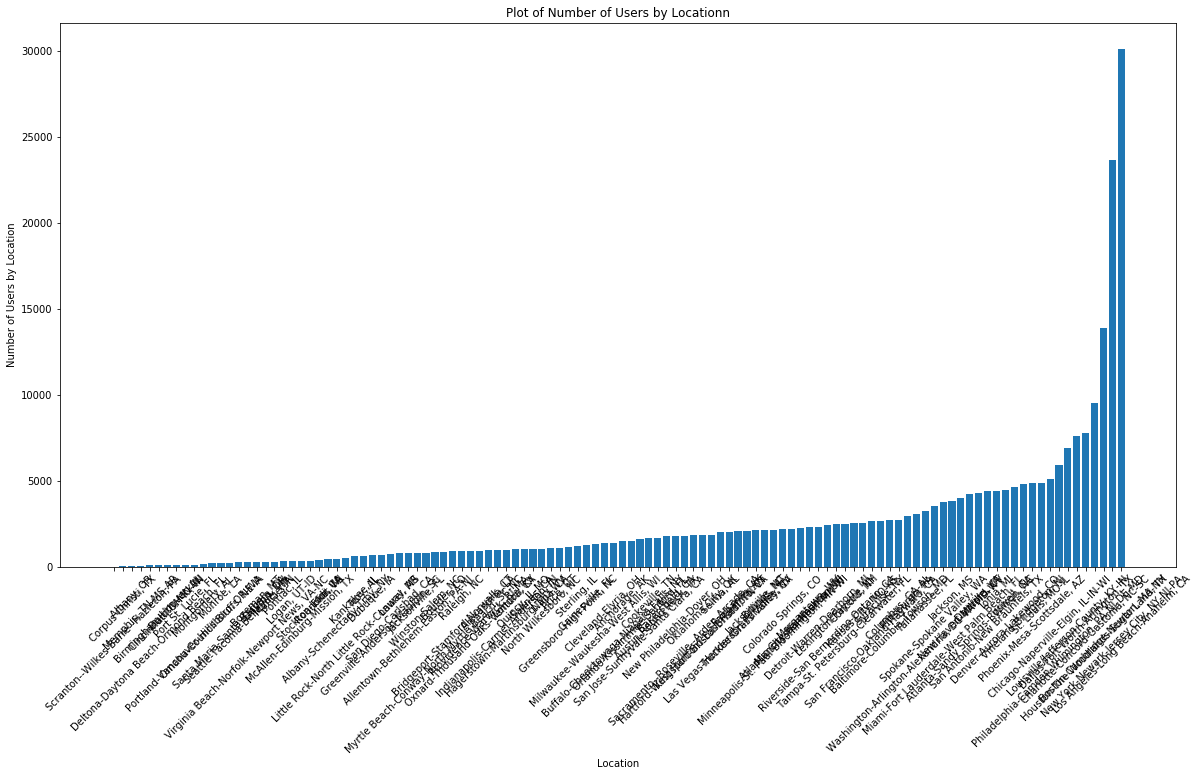

In [86]:
#Plot number of users by location
location_count = df.groupBy('location').count().orderBy("count").toPandas()
plt.figure(figsize = [40,10])
plt.bar(location_count['location'], location_count['count'])
plt.xticks(rotation = 90, fontsize=8)
plt.xlabel("Location")
plt.ylabel("Number of Users by Location")
plt.title("Plot of Number of Users by Locationn")

Text(0.5, 1.0, 'Plot of Number of Users by Locationn')

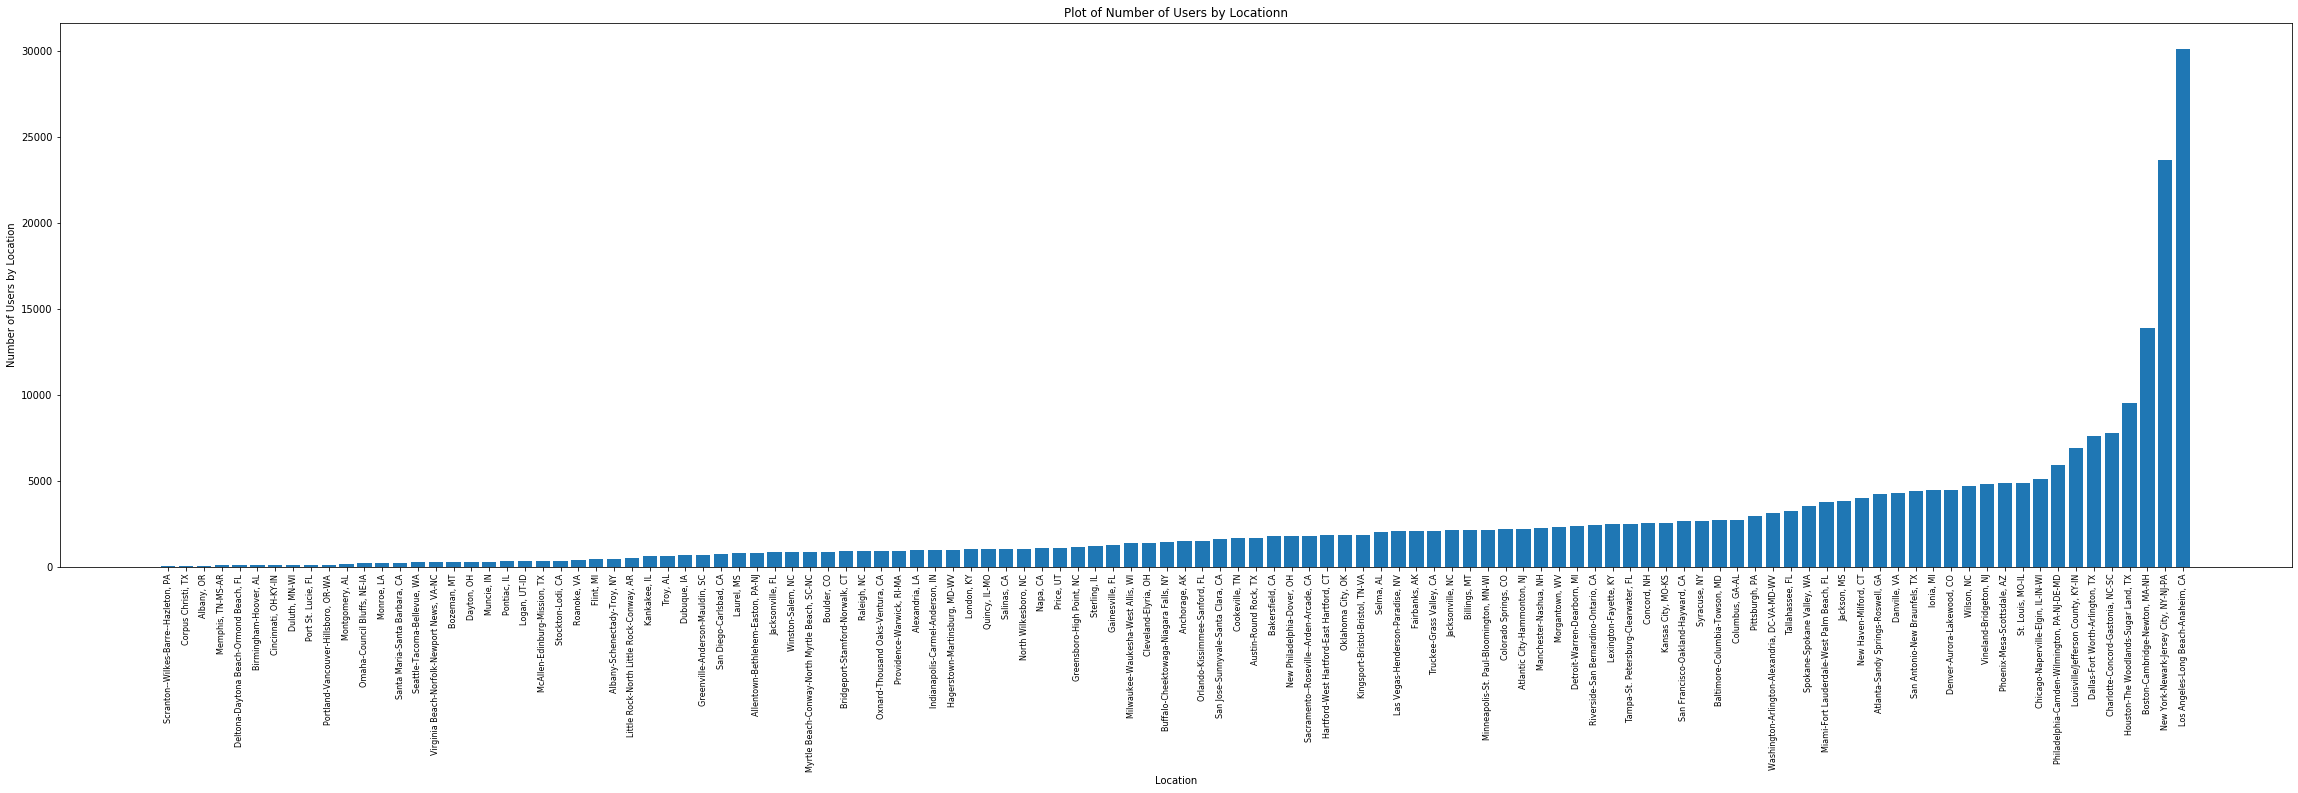

In [87]:
plt.figure(figsize = [40,10])
plt.bar(location_count['location'], location_count['count'])
plt.xticks(rotation = 90, fontsize=8)
plt.xlabel("Location")
plt.ylabel("Number of Users by Location")
plt.title("Plot of Number of Users by Locationn")

# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

In [80]:
cancel_churn = udf(lambda x: 1 if x == "Cancel" else 0, IntegerType())
df = df.withColumn("Cancel", cancel_churn("page"))


In [81]:
downgrade_churn = udf(lambda x: 1 if x == "Downgrade" else 0, IntegerType())
df = df.withColumn("Downgrade", cancel_churn("page"))
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)
 |-- Time: date (nullable = true)
 |-- Cancel: integer (nullable = true)
 |-- Downgrade: integer (nullable = true)



# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

In [17]:
spark.sql("SELECT * FROM df")

AnalysisException: 'Table or view not found: df; line 1 pos 14'

# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.

In [21]:
pd.read_json("mini_sparkify_event_data.json", lines=True)

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId
0,Martha Tilston,Logged In,Colin,M,50,Freeman,277.89016,paid,"Bakersfield, CA",PUT,NextSong,1.538173e+12,29,Rockpools,200,1538352117000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30
1,Five Iron Frenzy,Logged In,Micah,M,79,Long,236.09424,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1.538332e+12,8,Canada,200,1538352180000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9
2,Adam Lambert,Logged In,Colin,M,51,Freeman,282.82730,paid,"Bakersfield, CA",PUT,NextSong,1.538173e+12,29,Time For Miracles,200,1538352394000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30
3,Enigma,Logged In,Micah,M,80,Long,262.71302,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1.538332e+12,8,Knocking On Forbidden Doors,200,1538352416000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9
4,Daft Punk,Logged In,Colin,M,52,Freeman,223.60771,paid,"Bakersfield, CA",PUT,NextSong,1.538173e+12,29,Harder Better Faster Stronger,200,1538352676000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30
5,The All-American Rejects,Logged In,Micah,M,81,Long,208.29995,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1.538332e+12,8,Don't Leave Me,200,1538352678000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9
6,The Velvet Underground / Nico,Logged In,Micah,M,82,Long,260.46649,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1.538332e+12,8,Run Run Run,200,1538352886000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9
7,Starflyer 59,Logged In,Colin,M,53,Freeman,185.44281,paid,"Bakersfield, CA",PUT,NextSong,1.538173e+12,29,Passengers (Old Album Version),200,1538352899000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30
8,NaN,Logged In,Colin,M,54,Freeman,NaN,paid,"Bakersfield, CA",PUT,Add to Playlist,1.538173e+12,29,NaN,200,1538352905000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30
9,Frumpies,Logged In,Colin,M,55,Freeman,134.47791,paid,"Bakersfield, CA",PUT,NextSong,1.538173e+12,29,Fuck Kitty,200,1538353084000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30


In [76]:
windowval = Window.partitionBy("userId").orderBy(desc("time")).rangeBetween(Window.unboundedPreceding, 0)

In [82]:
user_log_valid = df.withColumn("phase", Fsum("Cancel").over(windowval))

In [85]:
user_log_valid.show(n=5)

PythonException: 
  An exception was thrown from the Python worker. Please see the stack trace below.
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\Lib\site-packages\pyspark\python\lib\pyspark.zip\pyspark\worker.py", line 605, in main
  File "C:\ProgramData\Anaconda3\Lib\site-packages\pyspark\python\lib\pyspark.zip\pyspark\worker.py", line 597, in process
  File "C:\ProgramData\Anaconda3\Lib\site-packages\pyspark\python\lib\pyspark.zip\pyspark\serializers.py", line 223, in dump_stream
    self.serializer.dump_stream(self._batched(iterator), stream)
  File "C:\ProgramData\Anaconda3\Lib\site-packages\pyspark\python\lib\pyspark.zip\pyspark\serializers.py", line 141, in dump_stream
    for obj in iterator:
  File "C:\ProgramData\Anaconda3\Lib\site-packages\pyspark\python\lib\pyspark.zip\pyspark\serializers.py", line 212, in _batched
    for item in iterator:
  File "C:\ProgramData\Anaconda3\Lib\site-packages\pyspark\python\lib\pyspark.zip\pyspark\worker.py", line 450, in mapper
  File "C:\ProgramData\Anaconda3\Lib\site-packages\pyspark\python\lib\pyspark.zip\pyspark\worker.py", line 450, in <genexpr>
  File "C:\ProgramData\Anaconda3\Lib\site-packages\pyspark\python\lib\pyspark.zip\pyspark\worker.py", line 88, in <lambda>
  File "C:\ProgramData\Anaconda3\Lib\site-packages\pyspark\python\lib\pyspark.zip\pyspark\util.py", line 107, in wrapper
    return f(*args, **kwargs)
  File "<ipython-input-46-639176be62a5>", line 2, in <lambda>
TypeError: an integer is required (got type str)
